### Load dependencies

In [25]:
import os
import shutil
import time
import pickle
import random
import pandas as pd
import librosa
import librosa.display
import gc
import numpy as np
import urllib
import umap
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import colorcet as cc
import math
import warnings
import seaborn as sns
import chirplet as ch
warnings.filterwarnings('ignore')
%matplotlib notebook

In [7]:
'''
path = '../sound_annotation_files_UMAP/'
csv = sorted(os.listdir(path))
sound_annotation_files = []
for i in csv:
    if i.endswith('.csv'):
        sound_annotation_files.append(path+i)

if len(sound_annotation_files)==1:
    labels= pd.read_csv(sound_annotation_files[0])
elif len(sound_annotation_files)==0:
    print('Must provide an annotation file')
elif len(sound_annotation_files)>1:
    labels = pd.read_csv(sound_annotation_files[0])
    for i in sound_annotation_files[1:]:
        tmp = pd.read_csv(i)
        labels = pd.concat([labels,tmp])
        
presences = labels[labels.validated == 'present']
absences = labels[labels.validated == 'not present']
not_validated = labels[labels.validated == '(not validated)']
print(len(presences), len(absences), len(not_validated))

not_validated.to_csv('../sound_annotation_files_splited/not_validated/not_validated.csv') #Data to augmentation
presences.to_csv('../sound_annotation_files_splited/presences/presences.csv') 
absences.to_csv('../sound_annotation_files_splited/absences/absences.csv') 
'''

22243 125257 4335150


In [9]:
recording_dir = '../../exp1/arbimon2-cnn/recordings/' # Folder holding recordings
labels = pd.read_csv('../sound_annotation_files_splited/presences/presences.csv')

In [10]:
callshape = []
for i in range(len(labels)):
    callshape.append(labels.iloc[i].species.replace(' ', '_') + '-' + labels.iloc[i].songtype.replace(' ', '_'))

labels.insert(loc=10, column='callshape', value=callshape)

In [11]:
print('Number of labels for each callshape:\n')

for i in sorted(list(set(labels.callshape))):
    print(str(i)+'\t\t'+str(len(labels[labels.callshape==i])))

Number of labels for each callshape:

Agelasticus_thilius-Alternative_Song		2551
Agelasticus_thilius-Alternative_Song_2		958
Agelasticus_thilius-Common_Song		1505
Anairetes_parulus-Common_Song		302
Cistothorus_platensis-Common_Song		1434
Colorhamphus_parvirostris-Common_Song		1256
Curaeus_curaeus-Common_Song		302
Curaeus_curaeus-Simple_Call		301
Elaenia_albiceps-Common_Song		1311
Elaenia_albiceps-Simple_Call		1438
Elaenia_albiceps-Simple_Call_2		1388
Eugralla_paradoxa-Common_Song		459
Gallinago_paraguaiae-Common_Song		1010
Glaucidium_nana-Common_Song		558
Glaucidium_nana-Territorial_Song		160
Mareca_sibilatrix-Simple_Call		1025
Mareca_sibilatrix-Simple_Call_2		27
Pardirallus_sanguinolentus-Common_Song		1318
Phleocryptes_melanops-Alternative_Song		1
Phleocryptes_melanops-Common_Song		638
Porzana_spiloptera-Common_Song		1413
Scytalopus_magellanicus-Common_Song		1018
Sicalis_luteola-Common_Song		721
Sicalis_luteola-Simple_Call		439
Troglodytes_aedon-Common_Song		710


In [12]:
T_aedon = labels[labels.species=='Troglodytes aedon']
E_paradoxa = labels[labels.species=='Eugralla paradoxa']
G_paraguaiae = labels[labels.species=='Gallinago paraguaiae']
P_melanops = labels[labels.species=='Phleocryptes melanops']
S_magellanicus = labels[labels.species=='Scytalopus magellanicus']
A_parulus = labels[labels.species=='Anairetes parulus']
C_curaeus = labels[labels.species=='Curaeus curaeus']
E_albiceps_a = labels[labels.callshape=='Elaenia_albiceps-Common_Song']           # callshape
E_albiceps_b = labels[labels.callshape=='Elaenia_albiceps-Simple_Call']           # callshape
E_albiceps_c = labels[labels.callshape=='Elaenia_albiceps-Simple_Call_2']         # callshape
G_nana_a = labels[labels.callshape=='Glaucidium_nana-Territorial_Song']           # callshape
G_nana_b = labels[labels.callshape=='Glaucidium_nana-Common_Song']                # callshape
P_sanguinolentus = labels[labels.species=='Pardirallus sanguinolentus']
S_luteola_a = labels[labels.callshape=='Sicalis_luteola-Common_Song']             # callshape
S_luteola_b = labels[labels.callshape=='Sicalis_luteola-Simple_Call']             # callshape
C_platensis = labels[labels.species=='Cistothorus platensis']
C_parvirostris = labels[labels.species=='Colorhamphus parvirostris']
M_sibilatrix = labels[labels.species=='Mareca sibilatrix']
A_thilius_a = labels[labels.callshape=='Agelasticus_thilius-Alternative_Song']    # callshape
A_thilius_b = labels[labels.callshape=='Agelasticus_thilius-Common_Song']         # callshape
A_thilius_c = labels[labels.callshape=='Agelasticus_thilius-Alternative_Song_2']  # callshape
P_spiloptera = labels[labels.species=='Porzana spiloptera']

labels_species = [T_aedon, E_paradoxa, G_paraguaiae, P_melanops, S_magellanicus, A_parulus, C_curaeus,
                     E_albiceps_a, E_albiceps_b, E_albiceps_c, G_nana_a, G_nana_b, P_sanguinolentus, S_luteola_a,
                      S_luteola_b, C_platensis, C_parvirostris, M_sibilatrix, 
                      A_thilius_a, A_thilius_b, A_thilius_c, P_spiloptera]

labels_species_str = ['T.aedon', 'E.paradoxa', 'G.paraguaiae', 'P.melanops', 'S.magellanicus', 'A.parulus', 'C.curaeus',
                     'E.albiceps (a)', 'E.albiceps (b)', 'E.albiceps (c)', 'G.nana (a)', 'G.nana (b)', 'P.sanguinolentus', 'S.luteola (a)',
                      'S.luteola (b)', 'C.platensis', 'C.parvirostris', 'M.sibilatrix', 
                      'A.thilius (a)', 'A.thilius (b)', 'A.thilius (c)', 'P.spiloptera']
print(len(labels_species), len(labels_species_str))

22 22


In [13]:
def create_melfeatures(df, 
                       sampling_rate, 
                       sample_time, 
                       n_fft, 
                       n_mels, 
                       hop_length, 
                       win_length,
                       fmin,
                       fmax):
    print(df.iloc[0,9])
    k = 0
    misssed = 0
    N_time_windows = math.ceil(round(sampling_rate*sample_time)/hop_length)
    MxN = n_mels*N_time_windows
    mel_features = []
    for i in list(set(df.url)): # loop over recordings
        tmp = df[df.url==i]
        audio_filename = tmp.iloc[0].url.split('download/')[1]
        for c in range(len(tmp)): # loop over labels in the same recording
            sound_start, sound_end = [tmp.iloc[c]['x1'], tmp.iloc[c]['x2']]
            shft = ((sound_end-sound_start)-sample_time)/2
            start_sample = round(sampling_rate*(sound_start+shft))
            end_sample = start_sample+round(sampling_rate*sample_time)
            try:
                audio_data, sr = librosa.load(recording_dir+audio_filename, sr=sampling_rate)
                S = librosa.feature.melspectrogram(y = audio_data[int(start_sample): int(end_sample)], 
                                                    sr = sr,
                                                    n_fft=n_fft,
                                                    n_mels=n_mels,
                                                    hop_length=hop_length, 
                                                    win_length=win_length,
                                                    fmin=fmin,
                                                    fmax=fmax)
                S = librosa.power_to_db(S, ref=np.max)
            except:
                #print('LIBROSA ERROR\n', audio_filename, sound_start, sound_end)
                misssed = misssed + 1
                continue
            #print(S.shape)
            if S.shape == (n_mels, N_time_windows):
                S_flat = np.reshape(S, MxN) #flatten melfeatures matrix S
                #print(S_flat.shape)
                mel_features.append(S_flat)
                k = k+1
                #print('label ',k)
            else:
                #print('cropped spectrogram')
                misssed = misssed + 1

    mel_features = np.stack(mel_features)
    #print(path_csv.split('/')[-1])
    print('Total samples correctly transformed (STFT-Mel) = ', k)
    print('Missed samples = ', misssed)
    print('Features extraction OK to UMAP. ' + 'Shape = ', mel_features.shape )
    print('\n')
    return(mel_features)

In [14]:
%%time

F = []
sample_ID = []
for i in range(len(labels_species)):                              
    ##### MEL-STFT #####
    F_tmp = create_melfeatures( df = labels_species[i],
                                sampling_rate = 44100,
                                sample_time = 1, 
                                n_fft = 2048, 
                                n_mels = 128, 
                                hop_length = 512, 
                                win_length = 1024,
                                fmin = 1024,
                                fmax = 16384
                                )
    
    F.append(F_tmp)
    sample_ID.append(np.full_like(F_tmp[:,0],i))
F = np.concatenate(F)
sample_ID = np.concatenate(sample_ID)

Troglodytes aedon
Total samples correctly transformed (STFT-Mel) =  710
Missed samples =  0
Features extraction OK to UMAP. Shape =  (710, 11136)


Eugralla paradoxa
Total samples correctly transformed (STFT-Mel) =  459
Missed samples =  0
Features extraction OK to UMAP. Shape =  (459, 11136)


Gallinago paraguaiae
Total samples correctly transformed (STFT-Mel) =  1010
Missed samples =  0
Features extraction OK to UMAP. Shape =  (1010, 11136)


Phleocryptes melanops
Total samples correctly transformed (STFT-Mel) =  639
Missed samples =  0
Features extraction OK to UMAP. Shape =  (639, 11136)


Scytalopus magellanicus
Total samples correctly transformed (STFT-Mel) =  1018
Missed samples =  0
Features extraction OK to UMAP. Shape =  (1018, 11136)


Anairetes parulus
Total samples correctly transformed (STFT-Mel) =  302
Missed samples =  0
Features extraction OK to UMAP. Shape =  (302, 11136)


Curaeus curaeus
Total samples correctly transformed (STFT-Mel) =  598
Missed samples =  5
Featu

In [20]:
sample_ID_str = []
for i in sample_ID:
    if i==0.0:
        sample_ID_str.append(labels_species_str[0])
    if i==1.0:
        sample_ID_str.append(labels_species_str[1])
    if i==2.0:
        sample_ID_str.append(labels_species_str[2])
    if i==3.0:
        sample_ID_str.append(labels_species_str[3])
    if i==4.0:
        sample_ID_str.append(labels_species_str[4])
    if i==5.0:
        sample_ID_str.append(labels_species_str[5])
    if i==6.0:
        sample_ID_str.append(labels_species_str[6])
    if i==7.0:
        sample_ID_str.append(labels_species_str[7])
    if i==8.0:
        sample_ID_str.append(labels_species_str[8])
    if i==9.0:
        sample_ID_str.append(labels_species_str[9])
    if i==10.0:
        sample_ID_str.append(labels_species_str[10])
    if i==11.0:
        sample_ID_str.append(labels_species_str[11])
    if i==12.0:
        sample_ID_str.append(labels_species_str[12])
    if i==13.0:
        sample_ID_str.append(labels_species_str[13])
    if i==14.0:
        sample_ID_str.append(labels_species_str[14])
    if i==15.0:
        sample_ID_str.append(labels_species_str[15])
    if i==16.0:
        sample_ID_str.append(labels_species_str[16])
    if i==17.0:
        sample_ID_str.append(labels_species_str[17])
    if i==18.0:
        sample_ID_str.append(labels_species_str[18])
    if i==19.0:
        sample_ID_str.append(labels_species_str[19])
    if i==20.0:
        sample_ID_str.append(labels_species_str[20])
    if i==21.0:
        sample_ID_str.append(labels_species_str[21])

In [59]:
reducer = umap.UMAP(random_state=42,
                    n_neighbors=20, 
                    min_dist=0.5 
                    #spread=0.5 
                    #init='spectral',
                    #negative_sample_rate=5
                   )

In [60]:
%%time
embedding = reducer.fit_transform(F)

CPU times: user 2min 32s, sys: 3.36 s, total: 2min 35s
Wall time: 36.2 s


In [100]:
colors = ['b',
          'mediumturquoise', #'whitesmoke',
          'mediumseagreen',
          
          'limegreen',
          'forestgreen',
          'cyan',
          
          'gold',
          'g',
          'dodgerblue',
          
          'coral',
          'peru',
          'orangered',
          
          'darkviolet',
          'sandybrown',
          'orchid',
          
          'indianred',
          'khaki',
          'orange',
          
          'mediumpurple',
          'darkblue',
          
          'tan',
          'crimson']
#random.shuffle(colors)

<IPython.core.display.Javascript object>


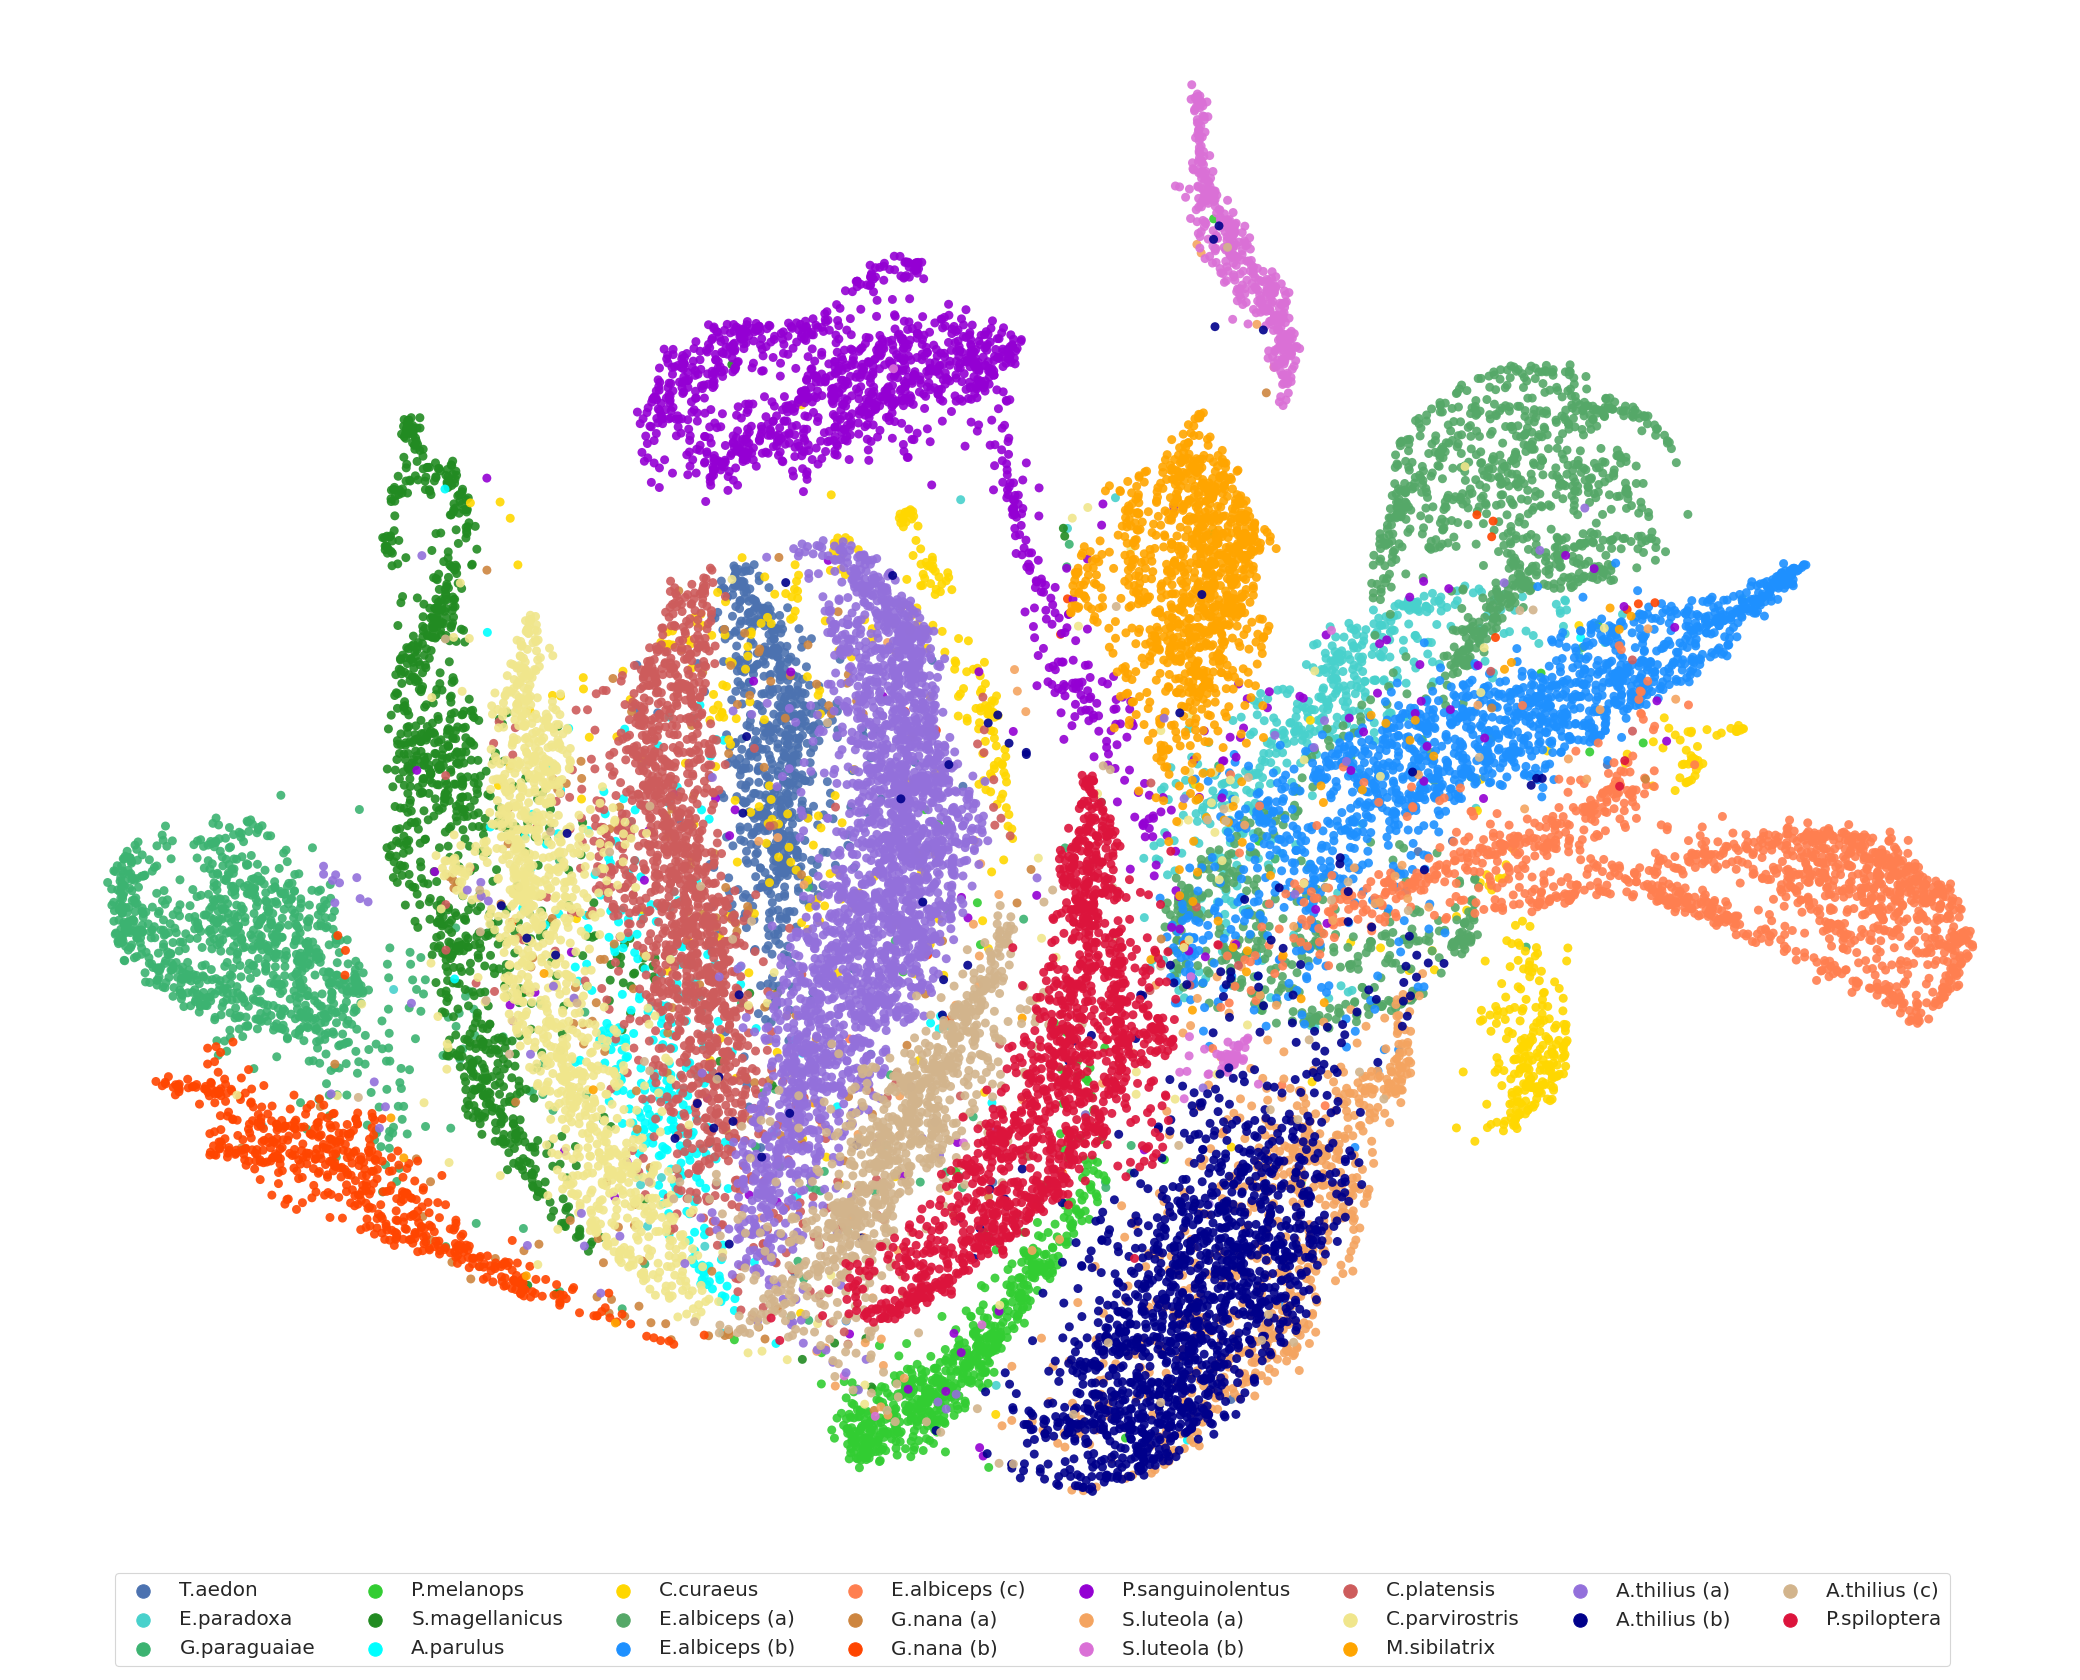

In [101]:
plt.figure(figsize=(26,21))
#plt.figure(figsize=(6,4))
sns.set(style='white')
sns.set(rc={'axes.facecolor':'#FFFFFF'})


palette = sns.color_palette(colors)

ax = sns.scatterplot(embedding[:,0], 
                     embedding[:, 1], 
                     hue=sample_ID_str, 
                     legend='full',
                     palette=palette, 
                     s=65,
                     #s=5,
                     alpha=0.9, 
                     linewidth=0)


sns.move_legend(ax, "lower left", 
                bbox_to_anchor=(0.098, -0.003), 
                borderaxespad=-5, 
                ncol=8, 
                title=None, 
                frameon=True, 
                fontsize=18, 
                markerscale=2,
               facecolor='white')

plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0, 1.135, 1.0])
plt.savefig('UMAP-DATASET-3sites_22class_128mels_1sec_n_neighbors=20_min_dist=0.5_random_state=42_color_white.png', format='png', dpi=300)
plt.show()
